## <center> Практическое домашнее задание 3 </center>

*`credits to ML course by E. Sokolov`*

### Общая информация

Дата выдачи: 16.04.2025

Первый дедлайн: 07:59MSK 18.05.2025

Второй дедлайн: 07:59MSK 20.05.2025

### Оглавление

В этом задании вы:

1. [ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии](#введение)
2. [познакомитесь с калибровкой вероятности](#калибровка)
3. [изучите методы трансформации переменных и методы отбора признаков](#кодировка)
4. [попробуете оценить экономический эффект модели](#модель)

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

**Штраф за каждый день просрочки мягкого дедлайна**: 0.5 баллов. После жесткого дедлайна работы не принимаются.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов.

❗️ Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо **указать ссылку на этот источник**.

**❗️ При использовании генеративных нейросетей:**

1. Необходимо указывать их как источник в каждом соответствующем задании
2. Ассистенты могут проводить мини-защиты ДЗ
3. Без указания как источника и подозрениях ассистентов, задания будут так же защищаться, иначе обнуляться.

# Часть 1. SVM, LR и калибровка вероятностей<a name="введение"></a>

*Максимум: 3 балла*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (1 балл)



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier


random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?

**Ваш Ответ**: так как мы предсказываем **вероятность** принадлежности к классу 1. А вероятность может быть от 0 до 1.

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


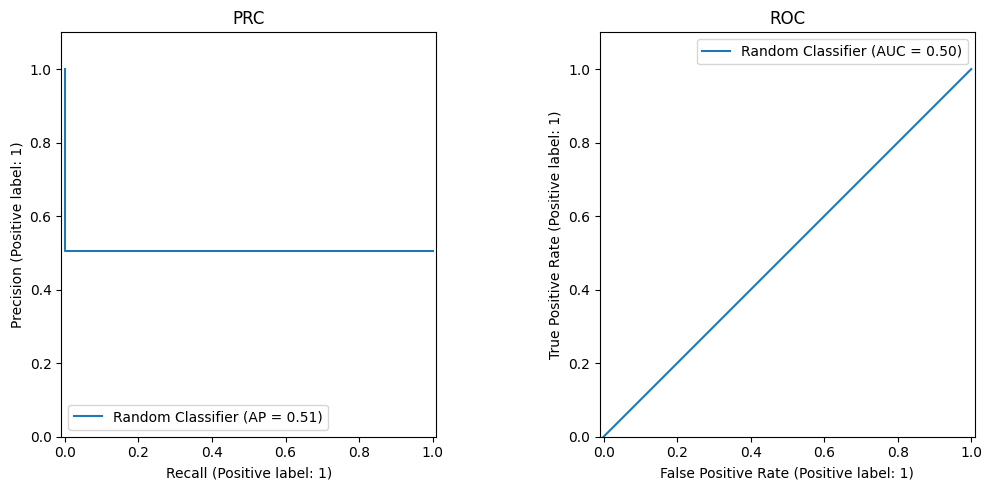

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    print('AUC-PR: %.5f' % auc(recall, precision))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [ ]:
# DataFrame для сравнения методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)

# Добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
C_value = np.logspace(-3, 2, 10)

svc = LinearSVC(random_state=42)

scorer = make_scorer(average_precision_score)

C_searcher = GridSearchCV(
    svc,
    param_grid={'C': C_value},
    scoring=scorer,
    cv=5
)

C_searcher.fit(X_train, y_train)


best_C   = C_searcher.best_params_['C']
svc_pred = C_searcher.decision_function(X_test) # предсказываем

print("Best C value = %.4f" % best_C)
print('SVC AUC-PR:', average_precision_score(y_test, svc_pred))

Best C value = 0.0010
SVC AUC-PR: 0.8295589687319155


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

Linear SVM metrics
AUC-PR: 0.82930
AUC-ROC: 0.84742


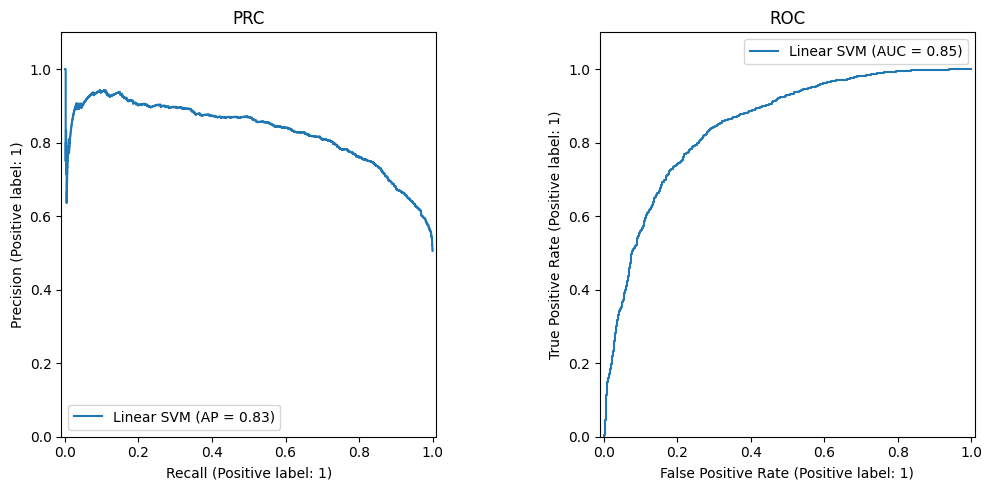

In [ ]:
depict_pr_roc(y_test, svc_pred, 'Linear SVM')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [ ]:
precision_svc, recall_svc, _ = precision_recall_curve(y_test, svc_pred)
auc_pr_svm = auc(recall_svc, precision_svc)
auc_roc_svm = roc_auc_score(y_test, svc_pred)

precision_rand, recall_rand, _ = precision_recall_curve(y_test, y_random)
auc_pr_rand = auc(recall_rand, precision_rand)
auc_roc_rand = roc_auc_score(y_test, y_random)

df_metrics.loc['Linear SVM'] = [
      auc_pr_svm,
      auc_roc_svm,
      best_C
]

print(f'AUC-PR улучшилась в {round(auc_pr_svm/auc_pr_rand, 2)}; AUC-ROC улучшилась в {round(auc_roc_svm/auc_roc_rand, 2)}')

AUC-PR улучшилась в 1.1; AUC-ROC улучшилась в 1.69


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
C_value = np.logspace(-3, 2, 10)

lr = LogisticRegression(penalty='l2', random_state=42)

scorer = make_scorer(average_precision_score)

C_searcher = GridSearchCV(
    lr,
    param_grid={'C': C_value},
    scoring=scorer,
    cv=5
)

C_searcher.fit(X_train, y_train)


best_C   = C_searcher.best_params_['C']
lr_pred = C_searcher.decision_function(X_test) # предсказываем

print("Best C value = %.4f" % best_C)
print('Logistic Regression AUC-PR:', average_precision_score(y_test, lr_pred))

precision_lr, recall_lr, _ = precision_recall_curve(y_test, lr_pred)

df_metrics.loc['Logistic Regression'] = [
      auc(recall_lr, precision_lr),
      roc_auc_score(y_test, lr_pred),
      best_C
]

Best C value = 0.1668
Logistic Regression AUC-PR: 0.829423466862137


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

In [ ]:
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.00000
Linear SVM,0.829297,0.847417,0.00100
Logistic Regression,0.829160,0.847868,0.16681


Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
Linear SVM metrics
AUC-PR: 0.82930
AUC-ROC: 0.84742
Logistic Regression metrics
AUC-PR: 0.82916
AUC-ROC: 0.84787


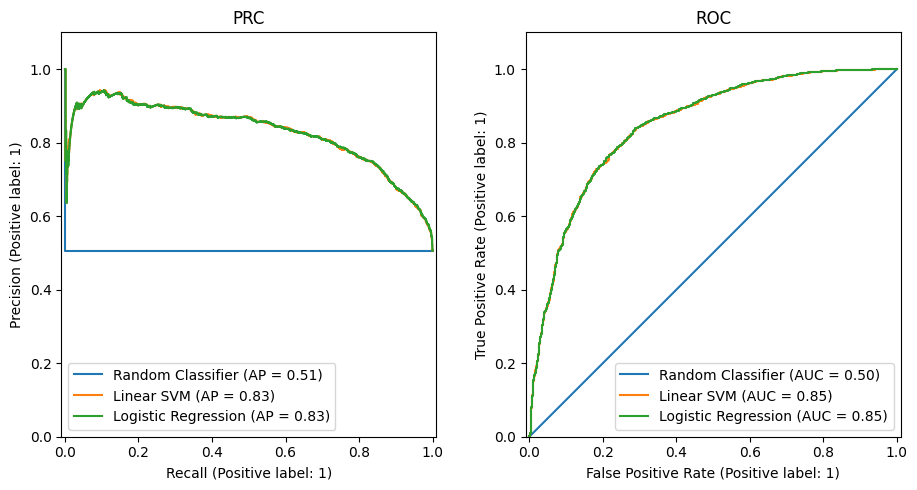

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, svc_pred, 'Linear SVM', ax=ax)
depict_pr_roc(y_test, lr_pred, 'Logistic Regression', ax=ax)

plt.tight_layout()
plt.legend()
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ваш Ответ:** Различия во всех критериях качества несущественны (порядка 4ой степени малости), что может свидетельствовать о том, что наши признаки линейно разделимы, поэтому ни одна из моделей не имеет какого-то преимущества перед другой.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)  <a name="калибровка"></a>

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [ ]:
from sklearn.svm import SVC

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X_train, y_train)

svc_pred = svc_model.predict(X_test)

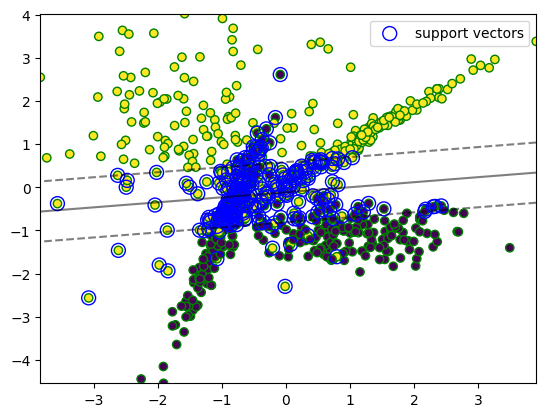

In [ ]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы уже обученной модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy) # .... your code here: что-то с decision_function
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку X
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="green")

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1], # .... your code here: координаты опорных векторов по осям х и у
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X_train, y_train, svc_model)

Заметим, что в неразделимых случаях опорные вектора - объекты нашей выборки - далеко не всегда оказываются на границах зазора.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [ ]:
logreg_model = LogisticRegression(random_state=42)

logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

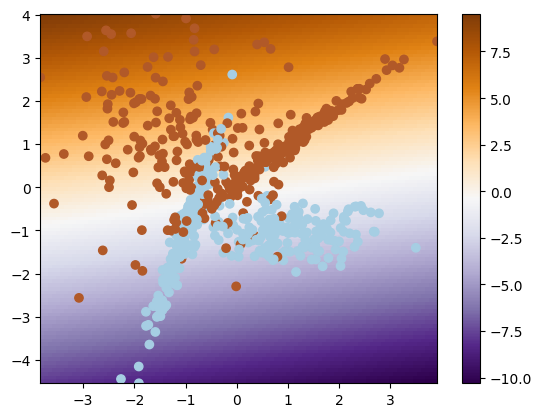

In [ ]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy)
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)
    plt.show()

plot_logreg_2D(X_train, y_train, logreg_model)

#### __Задание 2. Калибровка вероятностей__ (1.5 балла)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной кривой используем следующий алгоритм:

- Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

- Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц.

- Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. **В ней допущено две ошибки — найдите и исправьте их.**

In [ ]:
def plot_calibration_curve(y_test, preds, label=None):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label=label)
    plt.plot([0,1],[0,1],'--',color='gray', label='Идеально откалиброванная модель')
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Среднее предсказанное значение')
    plt.ylabel('Фактическая доля единичных ответов')
    plt.legend()
    plt.title("Калибровочные кривые")
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

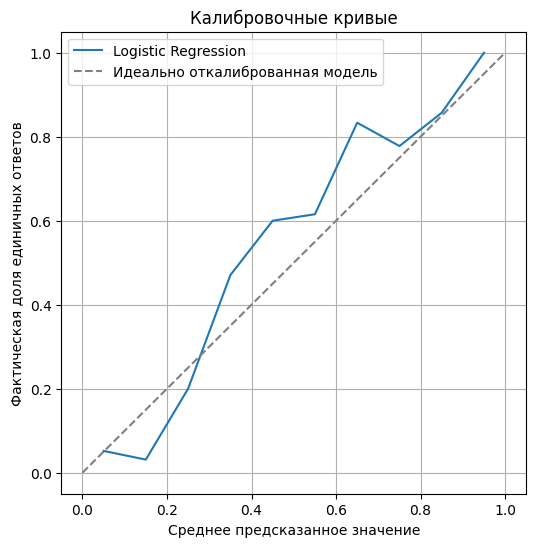

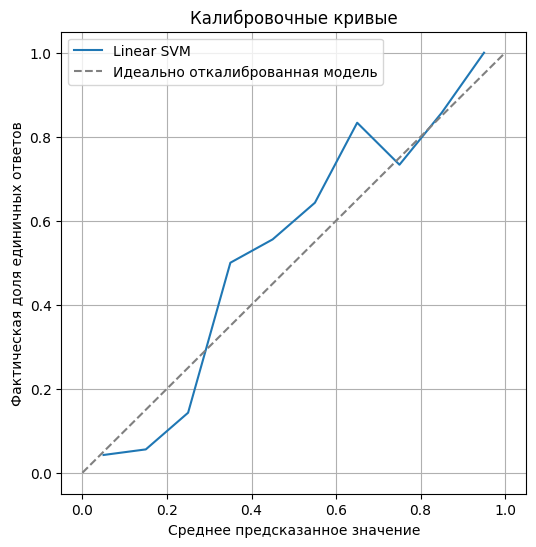

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2,
                           n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict_proba(X_test)[:, 1]

svc_model = SVC(kernel='linear', probability=True ,random_state=42)
svc_model.fit(X_train, y_train)
svc_preds = svc_model.predict_proba(X_test)[:, 1]


# обучили - вероятности на тесте - графики .... your code here
plot_calibration_curve(y_test, lr_preds, label='Logistic Regression')
plot_calibration_curve(y_test, svc_preds, label='Linear SVM')
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ваш Ответ:** Модели откалиброваны примерно одинаково. До 0,3 фактической доли правильных ответов обе модели "переоценивают" свои возможности, а от 0,3 до почти 0,8 - не дооценивают.

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

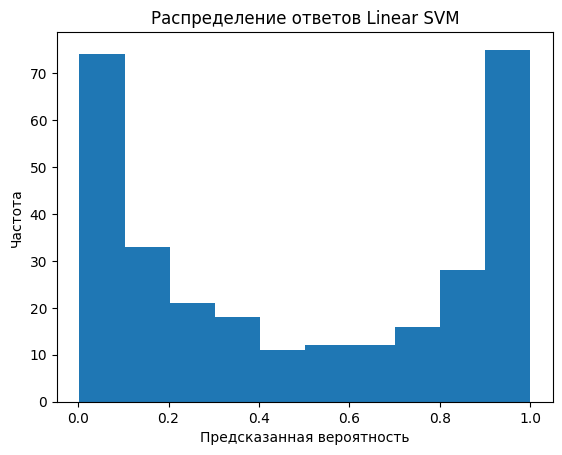

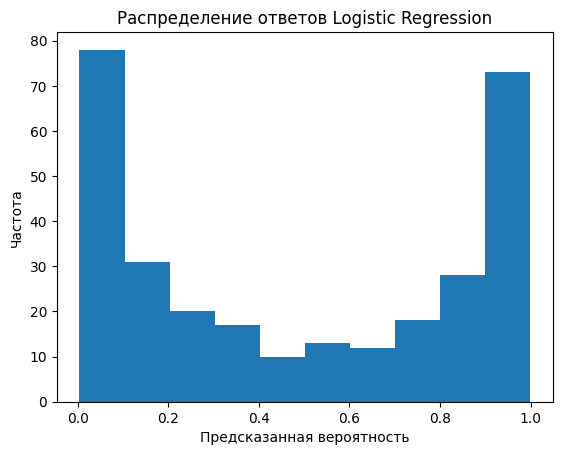

In [ ]:
plt.hist(svc_preds, bins=10)
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Частота')
plt.title("Распределение ответов Linear SVM")
plt.show()

plt.hist(lr_preds, bins=10)
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Частота')
plt.title("Распределение ответов Logistic Regression")
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ваш Ответ:** LogReg стабильно чуть лучше предсказывает и более уверена в ответах, за счет того что эта модель и настроена на расчет вероятности с помощью функции сигмоиды. А SVC при этом выдает на выходе не вероятности, а отступ, а перевод в вероятности является искусственным.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html).

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

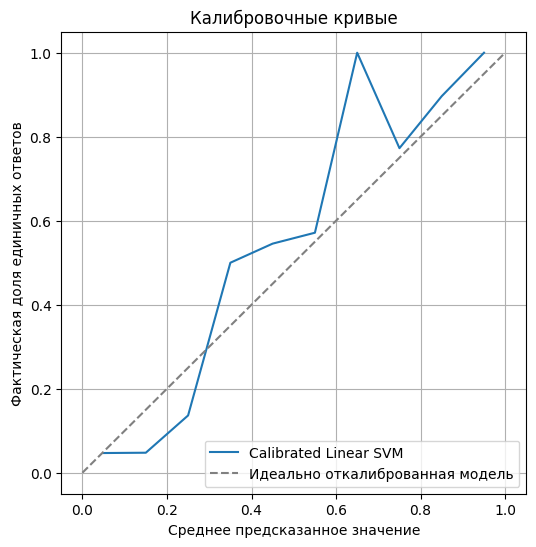

In [ ]:
calibrated_clf = CalibratedClassifierCV(svc_model, method='sigmoid')
calibrated_clf.fit(X_train, y_train)

calibrated_preds = calibrated_clf.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, calibrated_preds , label='Calibrated Linear SVM')
plt.show()

# обучение - предсказание - график .... your code here

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ваш Ответ:** Как будто хуже стало... Раньше, во-первых, не было недооценивания моделью аж до 1, а во-вторых, после 0,8 кривая была ближе к идеальной калибровочной

# Часть 2. Обработка категориальных переменных  <a name="кодировка"></a>


*Максимум: 6 баллов*

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед

- Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

- Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [ ]:
df = pd.read_csv('bike_buyers.csv')
#Заменим пропуски категориальных переменных

X = df.drop(columns=['Purchased Bike'])
categorical_cols = X.select_dtypes(include=object).columns
X[categorical_cols] = X[categorical_cols].fillna(value='undefined')
y = (df['Purchased Bike'] == 'Yes').astype('int64')


In [ ]:
X[categorical_cols].isna().sum()

,0
Marital Status,0
Gender,0
Education,0
Occupation,0
Home Owner,0
Commute Distance,0
Region,0


__Задание 2.1 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Что означает этот аргумент? Про `stratify` разбиение на train и test будет происходить так, чтобы соотношение классов в выборках train и test совпадало с исходным.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
# Разделим на категориальные признаки и числовые
X_numerical_train   = X_train.select_dtypes(exclude=object) # решение взято из https://stackoverflow.com/questions/58075048/separate-numerical-and-categorical-variable-in-pandas-datframe
X_numerical_test   = X_test.select_dtypes(exclude=object)
X_categorical_train = X_train[categorical_cols]
X_categorical_test = X_test[categorical_cols]

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

* Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии.

* Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: `AUC-ROC` лучше интерпретируется, когда балансы классов сбалансированны (строится график TPR от FPR и более репрезентативен, когда объектов класса 0 и класса 1 примерно одинаковое кол-во). А `AUC-PR` (график precision, recall) более репрезентативна при дисбалансе классов, за счет того, что фокусируется только на положительном классе (насколько модель точно и полно предсказывает положительный класс).

Затраченное время вместе с кодированием: 0.01725  (с)
AUC-PR: 0.57930


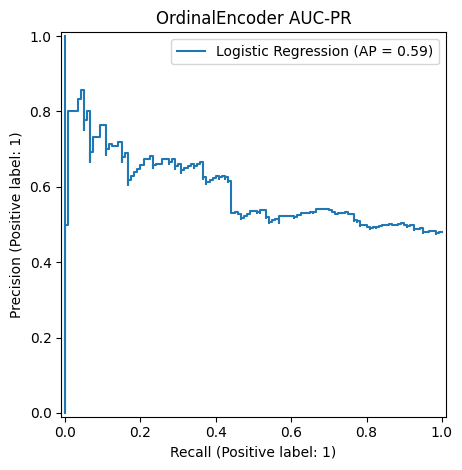

In [ ]:
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline

enc = OrdinalEncoder()
pipeline = Pipeline([
    ("encoder", enc),
    ("regressor", LogisticRegression(random_state=42))
    ])

start_timer = time.time()
pipeline.fit(X_categorical_train, y_train)
train_time = time.time() - start_timer

pipe_pred = pipeline.predict_proba(X_categorical_test)[:, 1]

precision_pipe, recall_pipe, _ = precision_recall_curve(y_test, pipe_pred)

print('Затраченное время вместе с кодированием: %.5f' % train_time, ' (с)')
print("AUC-PR: %.5f" % auc(recall_pipe, precision_pipe))

PrecisionRecallDisplay.from_predictions(y_test, pipe_pred, name='Logistic Regression')
plt.title('OrdinalEncoder AUC-PR')
plt.tight_layout()
plt.legend()
plt.show()

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

Я не поняла, почему в сравнении с тем, что было до кодирования? Мы же не обучали без кодирования в принципе. Или имеется в виду с OrdinalEncoder?

Затраченное время вместе с кодированием: 0.01595  (с)
AUC-PR: 0.57930


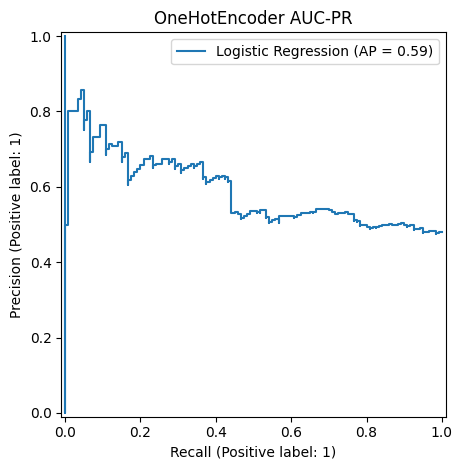

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
pipeline = Pipeline([
    ("encoder", enc),
    ("regressor", LogisticRegression(random_state=42))
    ])

start_timer = time.time()
pipeline.fit(X_categorical_train, y_train)
train_time = time.time() - start_timer

pipe_pred = pipeline.predict_proba(X_categorical_test)[:, 1]

precision_pipe, recall_pipe, _ = precision_recall_curve(y_test, pipe_pred)

print('Затраченное время вместе с кодированием: %.5f' % train_time, ' (с)')
print("AUC-PR: %.5f" % auc(recall_pipe, precision_pipe))

PrecisionRecallDisplay.from_predictions(y_test, pipe_pred, name='Logistic Regression')
plt.title('OneHotEncoder AUC-PR')
plt.tight_layout()
plt.legend()
plt.show()

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


Блин, у меня разница несильной получилась в кол-ве затрачиваемого времени (и качество тоже не изменилось)...

#### __Задание 5. Mean-target Encoding__ (2 балла)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

<ipython-input-68-1db339563e1c>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_target = X_categorical_train.groupby(col).apply(lambda idx: y_train[idx.index].mean())
<ipython-input-68-1db339563e1c>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_target = X_categorical_train.groupby(col).apply(lambda idx: y_train[idx.index].mean())
<ipython-input-68-1db339563e1c>:8: DeprecationWarning: DataFrame

Затраченное время вместе с кодированием: 0.03911  (с)
AUC-PR: 0.65264


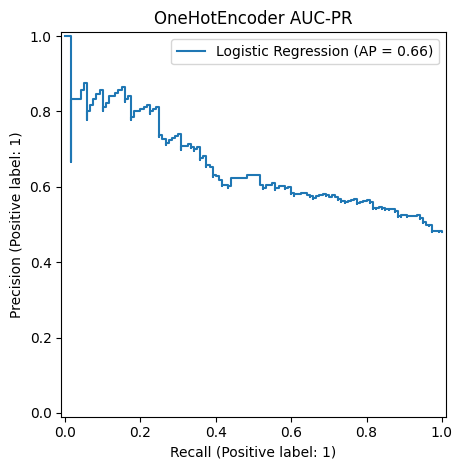

In [ ]:
# возможно, будет полезно вспомнить про метод groupby в pandas
X_train_enc = X_categorical_train.copy()
X_test_enc = X_categorical_test.copy()

start_timer = time.time()

for col in X_categorical_train.columns:
  mean_target = X_categorical_train.groupby(col).apply(lambda idx: y_train[idx.index].mean())
  X_train_enc[col] = X_categorical_train[col].map(mean_target)
  X_test_enc[col] = X_categorical_test[col].map(mean_target)

pipeline = Pipeline([
    ("regressor", LogisticRegression(random_state=42))
    ])

pipeline.fit(X_train_enc, y_train)
train_time = time.time() - start_timer

pipe_pred = pipeline.predict_proba(X_test_enc)[:, 1]

precision_pipe, recall_pipe, _ = precision_recall_curve(y_test, pipe_pred)

print('Затраченное время вместе с кодированием: %.5f' % train_time, ' (с)')
print("AUC-PR: %.5f" % auc(recall_pipe, precision_pipe))

PrecisionRecallDisplay.from_predictions(y_test, pipe_pred, name='Logistic Regression')
plt.title('OneHotEncoder AUC-PR')
plt.tight_layout()
plt.legend()
plt.show()
# .... your code here

Затраченное время на кодирование и обучение стало примерно в 4 раза больше. Качество стало лучше менее чем на 10%.

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [ ]:
import seaborn as sns

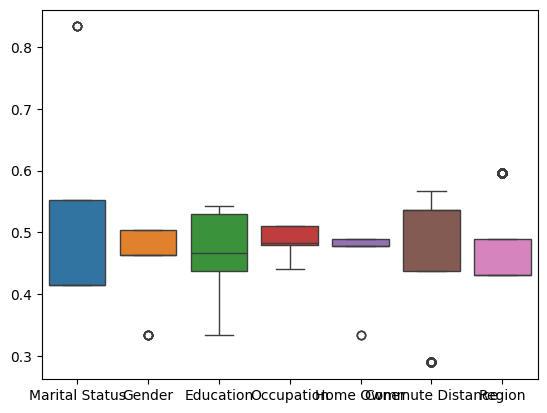

In [ ]:
# Решила посмотреть ящики с усами, чтобы понимать в целом, какой порядок шума еще информативен для признаков
sns.boxplot(X_train_enc)
plt.show()

In [ ]:
# .... your code here
# напомним про np.random.normal
noise = np.random.normal(loc=0, scale=0.02, size=X_train_enc.shape[1])
X_train_enc_noise = X_train_enc + noise

Затраченное время вместе с кодированием: 0.01240  (с)
AUC-PR: 0.65196


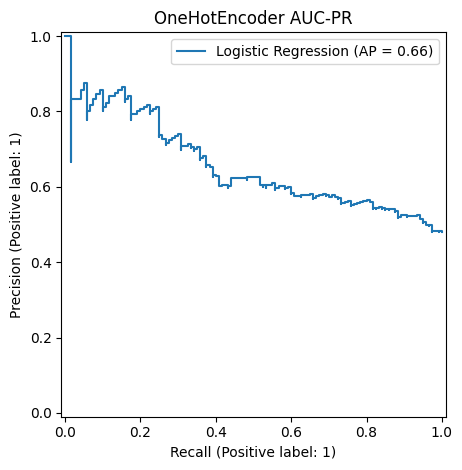

In [ ]:
start_timer = time.time()

pipeline = Pipeline([
    ("regressor", LogisticRegression(random_state=42))
    ])

pipeline.fit(X_train_enc_noise, y_train)
train_time = time.time() - start_timer

pipe_pred = pipeline.predict_proba(X_test_enc)[:, 1]

precision_pipe, recall_pipe, _ = precision_recall_curve(y_test, pipe_pred)

print('Затраченное время вместе с кодированием: %.5f' % train_time, ' (с)')
print("AUC-PR: %.5f" % auc(recall_pipe, precision_pipe))

PrecisionRecallDisplay.from_predictions(y_test, pipe_pred, name='Logistic Regression')
plt.title('OneHotEncoder AUC-PR')
plt.tight_layout()
plt.legend()
plt.show()

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ваш Ответ:** Даже чуть меньше стало качество (третий порядок малости). Возможно, отклонение от среднего малое (но до 0,05 я боялась добавлять, потому что это уже половина информативного диапазона). Возможно, также, что переобучение и не было в прошлый раз, а шумом мы только подпортили ситуацию (но не сильно, так как шум небольшой).

#### __Задание 7. Сглаживание счетчиков__  (1.5 балла)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Постарайтесь подобрать $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [ ]:
# .... your code here
# если пользуетесь методом groupby, напомним, что можно
# сначала вызвать его, а после разные функции агррегирования


<ipython-input-35-80c1c5526ce6>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_target = X_train.groupby(col).apply(lambda idx: y_train[idx.index].mean())
<ipython-input-35-80c1c5526ce6>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_target = X_train.groupby(col).apply(lambda idx: y_train[idx.index].mean())
<ipython-input-35-80c1c5526ce6>:10: DeprecationWarning: DataFrameGroupBy.apply operate

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [ ]:
X_numerical_train = X_numerical_train.fillna(X_numerical_train.mean())
X_numerical_test = X_numerical_test.fillna(X_numerical_train.mean())

In [ ]:
X_numerical_train.isna().sum()

,0
ID,0
Income,0
Children,0
Cars,0
Age,0


In [ ]:
X_train = pd.concat([X_train_enc, X_numerical_train], axis=1)
X_test = pd.concat([X_test_enc, X_numerical_test], axis=1)
X_train.head()

,Marital Status,Gender,Education,Occupation,Home Owner,Commute Distance,Region,ID,Income,Children,Cars,Age
345,0.415423,0.504155,0.529915,0.484848,0.478599,0.535581,0.488372,17894,20000.000000,1.0,0.0,50.0
540,0.552632,0.504155,0.543307,0.440559,0.478599,0.465116,0.430079,12195,70000.000000,3.0,2.0,52.0
110,0.552632,0.504155,0.437186,0.482759,0.489270,0.535581,0.488372,21006,56267.605634,1.0,0.0,46.0
902,0.552632,0.463158,0.529915,0.478947,0.478599,0.566667,0.430079,28858,80000.000000,3.0,0.0,40.0
15,0.552632,0.504155,0.466165,0.482759,0.478599,0.535581,0.488372,20870,10000.000000,2.0,1.0,38.0


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Затраченное время вместе с кодированием: 0.03178  (с)
AUC-PR: 0.66766


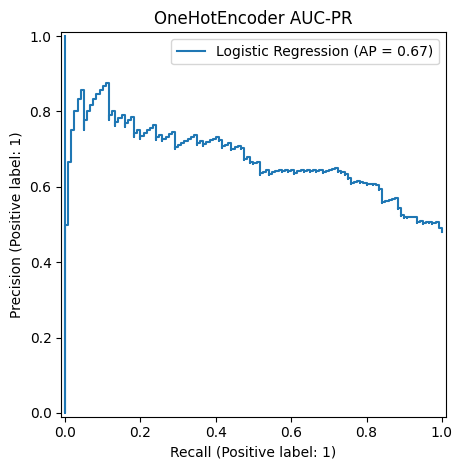

In [ ]:
start_timer = time.time()

pipeline = Pipeline([
    ("regressor", LogisticRegression(random_state=42))
    ])

pipeline.fit(X_train, y_train)
train_time = time.time() - start_timer

pipe_pred = pipeline.predict_proba(X_test)[:, 1]

precision_pipe, recall_pipe, _ = precision_recall_curve(y_test, pipe_pred)

print('Затраченное время вместе с кодированием: %.5f' % train_time, ' (с)')
print("AUC-PR: %.5f" % auc(recall_pipe, precision_pipe))

PrecisionRecallDisplay.from_predictions(y_test, pipe_pred, name='Logistic Regression')
plt.title('OneHotEncoder AUC-PR')
plt.tight_layout()
plt.legend()
plt.show()

С числовыми признаками улучшилось на 1%)) <br>
Или может я что-то не так сделала? Старалась учесть, чтобы числовые признаки не содержали пропусков и я не использовала данные категориальные с шумом из прошлой итерации (но с шумом был такой же результат)

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

# Часть 3. Оценка экономического эффекта модели  <a name="модель"></a>


*Максимум: 4 балла*

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что:

- выручка — это сколько денег нам принесли клиенты
- прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (2 балла)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2025-05-18 18:33:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [  <=>               ] 434.15K  1.43MB/s    in 0.3s    

2025-05-18 18:33:06 (1.43 MB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [ ]:
X.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
housing,object
loan,object
contact,object
month,object
day_of_week,object


В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=500)

* Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

* Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
  - Сколько денег вы в среднем заработаете?
  - Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [ ]:
cat_features = X.select_dtypes(include=object).columns.tolist()
num_features = X.select_dtypes(exclude=object).columns.tolist()

clf = ColumnTransformer([
    ('cat', OneHotEncoder(), cat_features),
    ('num', StandardScaler(), num_features)
    ])

pipeline = Pipeline([
    ('prep', clf),
    ('lr', LogisticRegression(random_state=42))
    ]) # .... your code here

profit, costs = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    calls = (y_pred == 1).sum()
    sales = ((y_pred == 1) & (y_test == 1)).sum()

    profit.append(10 * sales)
    costs.append(calls)

    # .... your code here

print('Выручка:\t', np.mean(profit))
print('Отклонение выручки:\t', np.std(profit))
print('Траты:\t', np.mean(costs))
print('Прибыль:\t', np.mean(np.array(profit)-np.array(costs)))
print('Отклонение прибыли:\t', np.std(np.array(profit) - np.array(costs)))

Выручка:	 2128.0
Отклонение выручки:	 91.9565114605812
Траты:	 322.2
Прибыль:	 1805.8
Отклонение прибыли:	 95.3003672605725


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [ ]:
# .... your code here
# для случайной величины можно использовать, например np.random.randint
profit, costs = [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    calls = (y_pred == 1).sum()
    sales = ((y_pred == 1) & (y_test == 1)).sum()

    profit.append(sales * np.random.randint(low=0, high=20))
    costs.append(calls)

    # .... your code here

print('Выручка:\t', np.mean(profit))
print('Отклонение выручки:\t', np.std(profit))
print('Траты:\t', np.mean(costs))
print('Прибыль:\t', np.mean(np.array(profit)-np.array(costs)))
print('Отклонение прибыли:\t', np.std(np.array(profit) - np.array(costs)))

Выручка:	 1423.2
Отклонение выручки:	 953.4582109353299
Траты:	 322.2
Прибыль:	 1101.0
Отклонение прибыли:	 954.8300372317578


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [ ]:
def profit_scorer(y_test, y_pred):
    # функция для кросс-валидации
    calls = (y_pred == 1).sum()
    sales = ((y_pred == 1) & (y_test == 1)).sum()
    income_sale = np.random.randint(low=0, high=20)
    outcome_call = 1
    return sales * income_sale - calls * outcome_call

C_grid = np.logspace(-3, 3, 10)   # .... your code here
C_searcher = GridSearchCV(
    estimator = pipeline,
    param_grid={'lr__C': C_grid},
    scoring=make_scorer(profit_scorer),
    cv=kf
    )

C_searcher.fit(X, y)

best_C   = C_searcher.best_params_['lr__C']

print("Best alpha = %.4f" % best_C)
print('Максимальная прибыль: ', C_searcher.best_score_)

Best alpha = 2.1544
Максимальная прибыль:  2239.6


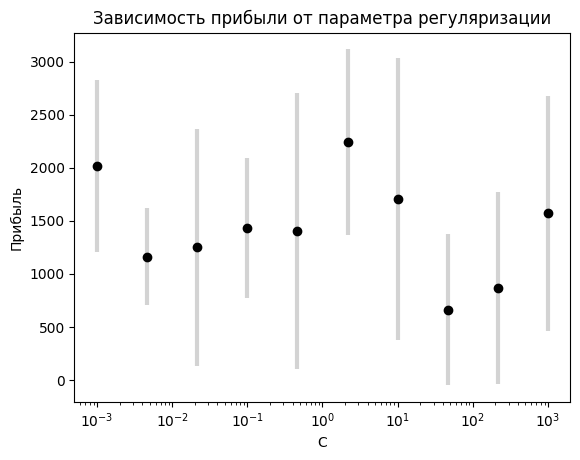

In [ ]:
params_C = C_searcher.cv_results_['param_lr__C']
scores_C = C_searcher.cv_results_['mean_test_score']
std_C = C_searcher.cv_results_['std_test_score']

plt.errorbar(params_C, scores_C, yerr=std_C, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Прибыль')
plt.title('Зависимость прибыли от параметра регуляризации')
plt.show()

#### __Задание 13. Ключевая метрика__ (2 балла)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Я считаю, что важнее Recall (перекрытие положительного класса), так как хороший recall позволяет нам максимизировать прибыль (то есть мы не упустили людей, которые бы хотели оформить депозит). Мне видится, что максимизация прибыли в recall'е способна перекрыть недочеты и потерю прибыли на precision'е (на один успешный звонок за 10$ (за это и отвечает recall), например, у нас есть 10 неудачных попыток позвонить человеку, который не возьмет продукт (precision), чтобы выйти в 0).



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [ ]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, auc

In [ ]:
def profit_scorer_with_threshold(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int) # вдохновлено https://habr.com/ru/articles/864794/
    calls = (y_pred == 1).sum()
    sales = ((y_pred == 1) & (y_true == 1)).sum()
    income_sale = np.random.randint(low=0, high=20)
    outcome_call = 1
    return sales * income_sale - calls * outcome_call

In [ ]:
thresholds = np.arange(0, 1.01, 0.01)
best_threshold = 0

profits, profits_std = [], []
precisions, recalls = [], []
best_profit = 0

# этот кусок кода обновлялся последовательно для еще и нескольких последующих заданий
for threshold in thresholds:
    profit_fold = []
    precision_fold = []
    recall_fold = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        pipeline.fit(X_train, y_train)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        profit = profit_scorer_with_threshold(y_test, y_pred_proba, threshold)
        profit_fold.append(profit)

        y_pred = (y_pred_proba >= threshold).astype(int)
        precision_fold.append(precision_score(y_test, y_pred))
        recall_fold.append(recall_score(y_test, y_pred))

    profits.append(np.mean(profit_fold))
    profits_std.append(np.std(profit_fold))
    precisions.append(np.mean(precision_fold))
    recalls.append(np.mean(recall_fold))

    if np.mean(profit_fold) > best_profit:
        best_profit = np.mean(profit_fold)
        best_threshold = threshold

print(f"Лучший порог: {best_threshold}")
print(f"Прибыль при лучшем пороге: {best_profit}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p

Лучший порог: 0.17
Прибыль при лучшем пороге: 5370.4


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Лучший порог: 0.11 <br>
Прибыль при лучшем пороге: 5309.2 <br>
Как раз, чем ближе порог к нулю, тем больше у нас recall, так как у нас по сути почти нет FN решений --> recall стремится к 1. Значит, выше я определила верную метрику. <br>
(Высвечивающиеся значения в ячейке могут отличаться от написанных, потому что запускаал несколько раз)

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




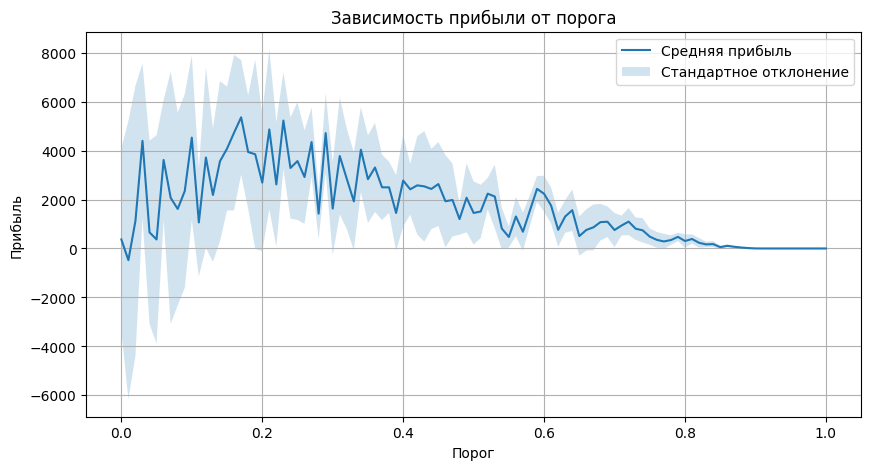

In [ ]:
# .... your code here
plt.figure(figsize=(10, 5))
plt.plot(thresholds, profits, label='Средняя прибыль')
plt.fill_between(
    thresholds,
    np.array(profits) - np.array(profits_std),
    np.array(profits) + np.array(profits_std),
    alpha=0.2,
    label='Стандартное отклонение'
)
plt.xlabel('Порог')
plt.ylabel('Прибыль')
plt.title('Зависимость прибыли от порога')
plt.grid()
plt.legend()
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ Закономерность, что чем ближе порог к 1, тем меньше разброс значений. И наоборот, чем ближе к 0, тем больше разброс. Это происходит потому что при высоких порогах модель делает меньше предсказаний "1" и
значение recall стремятся к 0, а precision - к стабильному близкому к 1 значению. Это значит, что межфолдовое колебание метрик меньше к 1.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [ ]:
idx_thresh = np.where(thresholds == best_threshold)[0][0]
print(f"Precision при лучшем пороге: {precisions[idx_thresh]:.4f}")
print(f"Recall  при лучшем пороге: {recalls[idx_thresh]:.4f}")
print(f"СКО прибыли при этом пороге: {profits_std[idx_thresh]:.4f}")

Precision при лучшем пороге: 0.4054
Recall  при лучшем пороге: 0.5902
СКО прибыли при этом пороге: 2350.0893
